In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sb
import scikitplot
from matplotlib import pyplot as plotGraph
from sklearn.metrics import classification_report, accuracy_score

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import layers
import keras.utils as np_utils
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, SimpleRNN
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# uncomment from 
# od.download("https://www.kaggle.com/datasets/deadskull7/fer2013")



In [ ]:
fer2013_df = pd.read_csv("/content/drive/MyDrive/17644_MoodDetectives/Datasets/fer2013.csv")

print("Number of images: ", len(fer2013_df))

fer2013_df.head(5)

Number of images:  35887


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
# number of unique emotions in dataset
fer2013_df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

<Axes: xlabel='emotion', ylabel='count'>

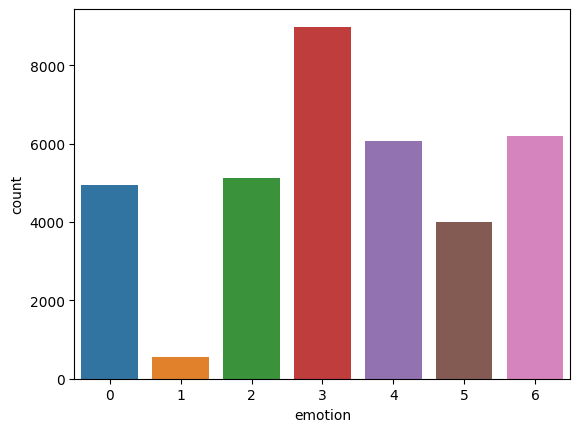

In [ ]:
sb.countplot(x=fer2013_df.emotion)

In [ ]:
emotion_labels = {
    0: "anger",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "suprise",
    6: "neutral"
}

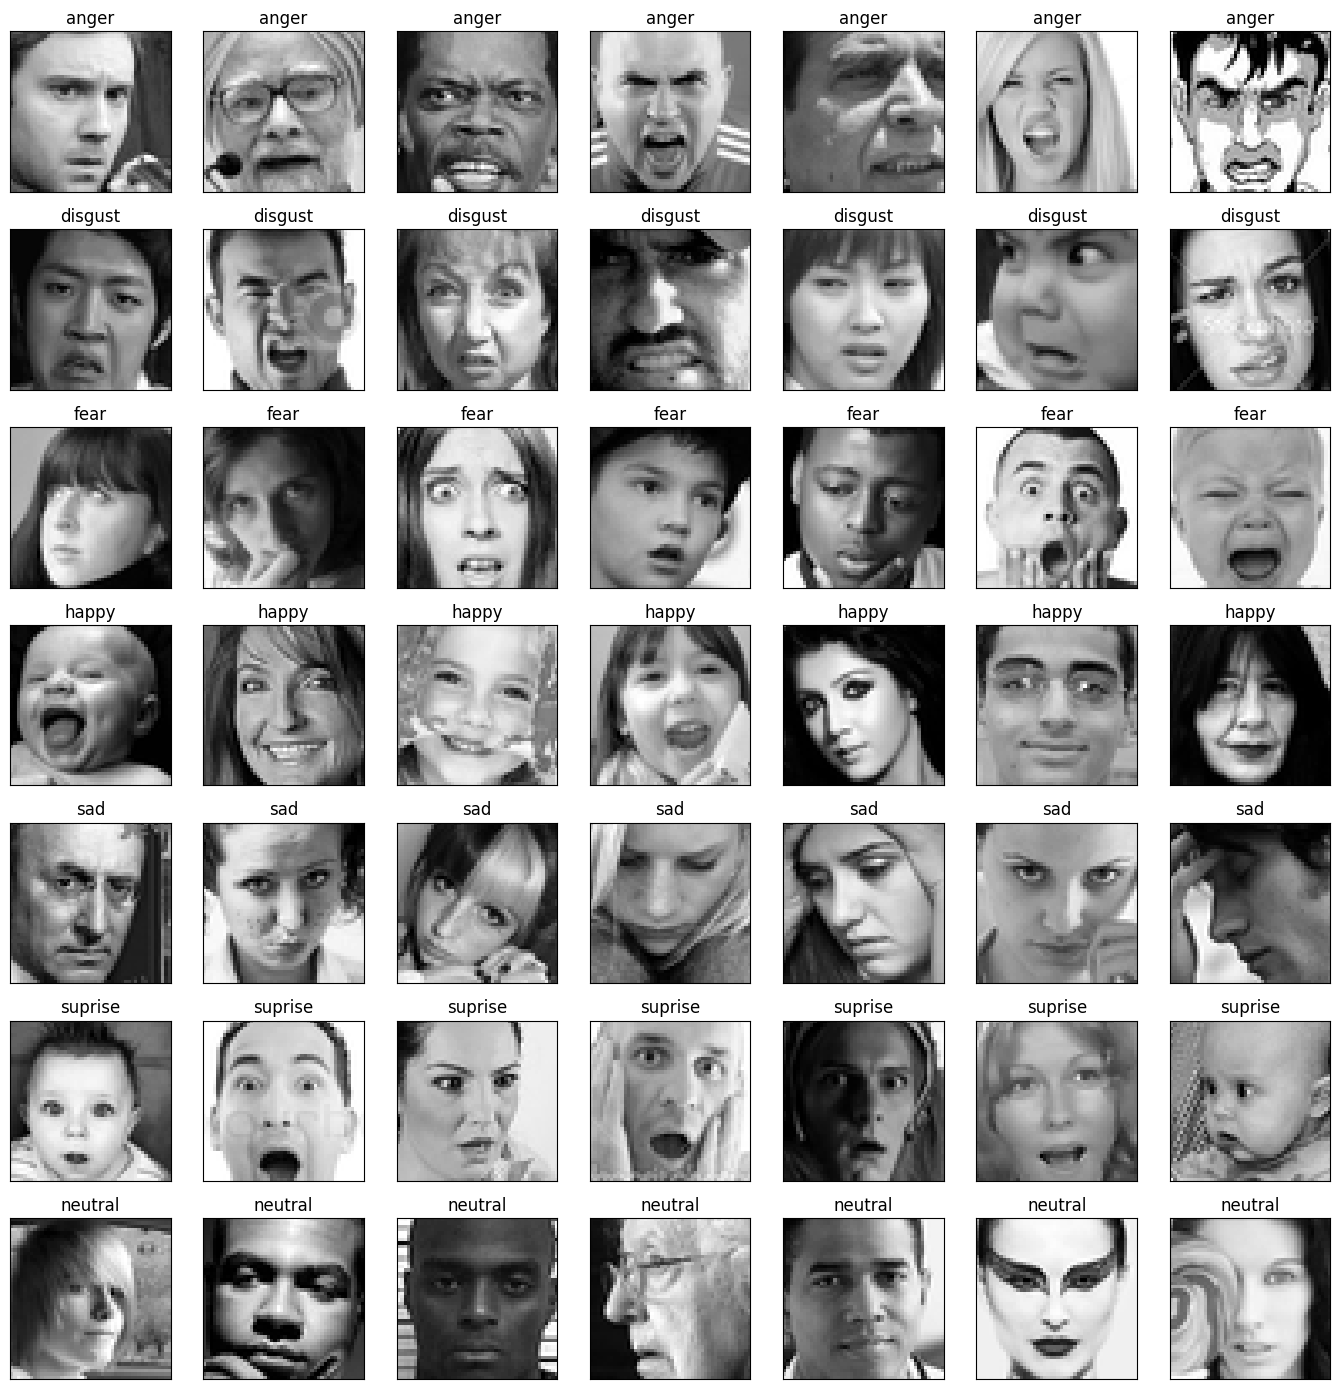

In [ ]:
# display example images for each emotion in dataset
fig = plotGraph.figure(1,(14,14))

k = 0

for label in sorted(fer2013_df.emotion.unique()):
  for j in range(7):
    px = fer2013_df[fer2013_df.emotion == label].pixels.iloc[k]
    px = np.array(px.split(" ")).reshape(48,48).astype("float32")

    k += 1

    ax = plotGraph.subplot(7,7,k)
    ax.imshow(px, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title(emotion_labels[label])
    plotGraph.tight_layout()

In [ ]:
#  only focus on three emotions: happy, sad, nuetral
EMOTIONS_TO_FOCUS_ON = [0,3,5]

fer2013_df = fer2013_df[
    fer2013_df.emotion.isin(EMOTIONS_TO_FOCUS_ON)
]

# get same of new dataset
fer2013_df.shape

(17944, 3)

In [ ]:
img_array = fer2013_df.pixels.apply(lambda x:
                                    np.array(x.split(" ")).reshape(48,48).astype(
                                        "float32"))

img_array = np.stack(img_array, axis=0)

img_array.reshape

<function ndarray.reshape>

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(fer2013_df.emotion)
img_labels = np_utils.to_categorical((img_labels))
img_labels.shape

(17944, 3)

In [ ]:
fer2013_df.emotion.unique()

array([0, 3, 5])

In [ ]:
le_name_mapping = dict(
    zip(le.classes_, le.transform(le.classes_))
)

le_name_mapping

{0: 0, 3: 1, 5: 2}

In [ ]:
# split data into train and test data

x_Train, x_Test, y_Train, y_Test = train_test_split(
    img_array,
    img_labels,
    shuffle=True,
    stratify = img_labels,
    test_size = .2,
    random_state=42
)

In [ ]:
# normalize data
x_Train = x_Train/255
x_Test = x_Test/255

In [ ]:
img_width = x_Train.shape[1]
img_height = x_Train.shape[2]

num_classes = y_Train.shape[1]

In [ ]:
img_width

48

In [ ]:
img_height

48

# Build Model (RNN)





## RNN Model Using Paper 2 Implementation

In [ ]:
## build RNN model from paper 2

def build_RNN_from_paper2(optim):
  net = Sequential(name="Three_Emotion_RNN_From_Paper_2")

  net.add(
      SimpleRNN(
          units=64,
          input_shape = (img_width, img_height),
          activation = "relu",
          return_sequences = True,
          name = "paper2_simpleRNN_1"
                )
  )

  net.add((Dropout(0.4, name="paper2_dropout_1")))


  net.add(
      SimpleRNN(
          units=64,
          activation = "relu",
          # return_sequences = True,
          name = "paper2_simpleRNN_2"
                )
  )


  net.add((Dropout(0.5, name="paper2_dropout_2")))


  net.add(
      Dense(
          num_classes,
          activation = "softmax",
          name = "paper2_outter_layer"
      )
  )

  net.compile(
      loss="categorical_crossentropy",
      optimizer= optim,
      metrics = ["accuracy"]
  )

  net.summary()

  return net


## RNN With More Layers

In [ ]:
# build RNN model

def build_RNN(optim):
  net = Sequential(name="Three_Emotion_RNN")

  net.add(
      SimpleRNN(
          units=64,
          input_shape = (img_width, img_height),
          activation = "relu",
          return_sequences = True,
          name = "simpleRNN_1"
                )
  )
  net.add(BatchNormalization(name = "batchnorm_1"))

  net.add(
      SimpleRNN(
          units=64,
          activation = "relu",
          return_sequences = True,
          name = "simpleRNN_2"
                )
  )
  net.add(BatchNormalization(name = "batchnorm_2"))
  net.add((Dropout(0.4, name="dropout_1")))

  net.add(
      SimpleRNN(
          units=64,
          activation = "relu",
          return_sequences = True,
          name = "simpleRNN_3"
                )
  )
  net.add(BatchNormalization(name = "batchnorm_3"))

  net.add(
      SimpleRNN(
          units=64,
          activation = "relu",
          return_sequences = True,
          name = "simpleRNN_4"
                )
  )
  net.add(BatchNormalization(name = "batchnorm_4"))
  net.add((Dropout(0.4, name="dropout_2")))

  net.add(
       SimpleRNN(
          units=64,
          activation = "relu",
          return_sequences = True,
          name = "simpleRNN_5"
                )
  )
  net.add(BatchNormalization(name = "batchnorm_5"))

  net.add(
      SimpleRNN(
          units=64,
          activation = "relu",
          # return_sequences = True,          
          name = "simpleRNN_6"
                )
  )
  net.add(BatchNormalization(name = "batchnorm_6"))
  net.add((Dropout(0.5, name="dropout_3")))


  net.add(
      Dense(
          128,
          activation = "relu",
          kernel_initializer = "he_normal",
          name = "dense_1"

      )
  )

  net.add(BatchNormalization(name="batchnorm_7"))
  net.add(Dropout(0.6, name="dropout_4"))

  net.add(
      Dense(
          num_classes,
          activation = "softmax",
          name = "outter_layer"
      )
  )

  net.compile(
      loss="categorical_crossentropy",
      optimizer= optim,
      metrics = ["accuracy"]
  )

  net.summary()

  return net


## Callback and Optimizer Setup For Model 1 and 2

In [ ]:
batch_size = 32
epochs = 100
steps_per_epoch = len(x_Train)/batch_size


early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    min_delta = 0.00005,
    patience = 11,
    verbose =1,
    restore_best_weights = True
    )

lr_scheduler = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 7,
    min_lr = 1e-7,
    verbose = 1

)


google_path_paper2 ="/content/drive/MyDrive/17644_MoodDetectives/RNN_Models-Three_Emotions/5_Layer_RNN_Model/Three_Emotions/FER2013/Checkpoints/"

google_path_new_model ="/content/drive/MyDrive/17644_MoodDetectives/RNN_Models-Three_Emotions/19_Layer_RNN_Model/Three_Emotions/FER2013/Checkpoints/"


model_checkpoints_paper2 = ModelCheckpoint(
    filepath = google_path_paper2 + "rnn_fer2013_model_epoch{epoch}.h5",
    save_weights_only=False,
    save_freq = int(5* steps_per_epoch), # save model every 5 epochs
    verbose = 1
    
)

new_model_checkpoints = ModelCheckpoint(
    filepath = google_path_new_model + "rnn_fer2013_model_epoch{epoch}.h5",
    save_weights_only=False,
    save_freq = int(5* steps_per_epoch), # save model every 5 epochs
    verbose = 1
    
)


callbacks_paper2 = [
    early_stopping,
    model_checkpoints_paper2,
    lr_scheduler
]


callbacks_new_model = [
    early_stopping,
    new_model_checkpoints,
    lr_scheduler
]

In [ ]:
optims = [
    optimizers.Nadam(
        learning_rate = .001,
        beta_1 = 0.9,
        beta_2 = 0.999,
        epsilon = 1e-07,
        name = "Nadam"
    ),
    optimizers.Adam(0.001),
    optimizers.legacy.Adam(0.001),
]

In [ ]:
model_from_paper2 = build_RNN_from_paper2(optims[2])        

Model: "Three_Emotion_RNN_From_Paper_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 paper2_simpleRNN_1 (SimpleR  (None, 48, 64)           7232      
 NN)                                                             
                                                                 
 paper2_dropout_1 (Dropout)  (None, 48, 64)            0         
                                                                 
 paper2_simpleRNN_2 (SimpleR  (None, 64)               8256      
 NN)                                                             
                                                                 
 paper2_dropout_2 (Dropout)  (None, 64)                0         
                                                                 
 paper2_outter_layer (Dense)  (None, 3)                195       
                                                                 
Total params: 15,683
Trainable param

In [ ]:
y_Test.shape

(3589, 3)

In [ ]:
y_Train.shape

(14355, 3)

In [ ]:
history_of_model_from_paper2 = model_from_paper2.fit(
    x_Train, y_Train,
    validation_data = (x_Test, y_Test),
    steps_per_epoch = len(x_Train)/batch_size,
    epochs=epochs,
    callbacks = callbacks_paper2,
    use_multiprocessing = True
    )

Epoch 1/100
448/448 [==============================] - 43s 91ms/step - loss: 1.0483 - accuracy: 0.4877 - val_loss: 0.9965 - val_accuracy: 0.5079 - lr: 0.0010
Epoch 2/100
448/448 [==============================] - 42s 93ms/step - loss: 0.9892 - accuracy: 0.5299 - val_loss: 0.9827 - val_accuracy: 0.5534 - lr: 0.0010
Epoch 3/100
448/448 [==============================] - 38s 85ms/step - loss: 0.9504 - accuracy: 0.5557 - val_loss: 0.9362 - val_accuracy: 0.5656 - lr: 0.0010
Epoch 4/100
448/448 [==============================] - 40s 89ms/step - loss: 0.9234 - accuracy: 0.5726 - val_loss: 0.9055 - val_accuracy: 0.5793 - lr: 0.0010
Epoch 5/100
445/448 [============================>.] - ETA: 0s - loss: 0.9053 - accuracy: 0.5831
Epoch 5: saving model to /content/drive/MyDrive/17644_MoodDetectives/RNN_Models-Three_Emotions/5_Layer_RNN_Model/Three_Emotions/FER2013/Checkpoints/rnn_fer2013_model_epoch5.h5
448/448 [==============================] - 38s 85ms/step - loss: 0.9054 - accuracy: 0.5831 - va

# Evaluate Model

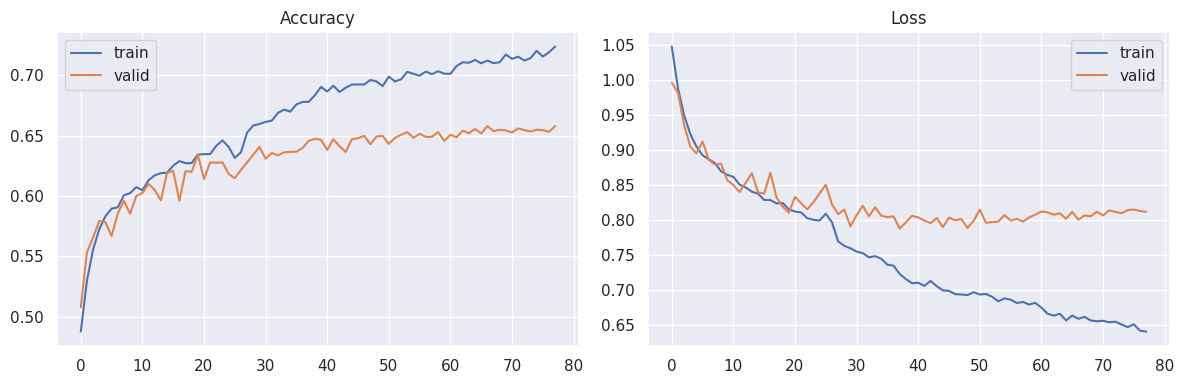

In [ ]:
# metrics

sb.set()
figure = plotGraph.figure(0, (12,4))

# Plot Accuracy
ax = plotGraph.subplot(1,2,1)
sb.lineplot(
    x = history_of_model_from_paper2.epoch,
    y = history_of_model_from_paper2.history["accuracy"], 
    label="train"
)

sb.lineplot(
    x = history_of_model_from_paper2.epoch,
    y = history_of_model_from_paper2.history["val_accuracy"], 
    label="valid"
)

plotGraph.title("Accuracy")
plotGraph.tight_layout()

# Plot Loss
ax = plotGraph.subplot(1,2,2)
sb.lineplot(
    x = history_of_model_from_paper2.epoch,
    y = history_of_model_from_paper2.history["loss"], 
    label="train"
)

sb.lineplot(
    x = history_of_model_from_paper2.epoch,
    y = history_of_model_from_paper2.history["val_loss"], 
    label="valid"
)

plotGraph.title("Loss")
plotGraph.tight_layout()

In [ ]:
# acccuracy

paper2_model_prediction = model_from_paper2.predict(x_Test)

accuracy_score( np.argmax(y_Test,axis=1) , np.argmax(paper2_model_prediction, axis =1) )

113/113 [==============================] - 1s 9ms/step


0.65784341042073

113/113 [==============================] - 1s 9ms/step


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

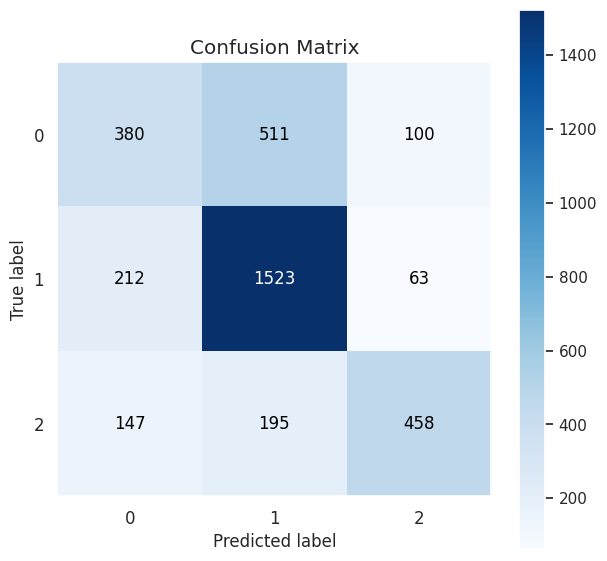

In [ ]:
# Confusion Matrix

paper2_model_predictions = model_from_paper2.predict(x_Test)
paper2_model_class_predictions = np.argmax(paper2_model_predictions, axis=1)

scikitplot.metrics.plot_confusion_matrix(
    np.argmax(y_Test, axis=1),
    paper2_model_class_predictions,
    figsize=(7,7)
)

In [ ]:
print(
    "Total Wrong Predictions:", 
      np.sum(
          np.argmax(y_Test, axis=1) != paper2_model_class_predictions
      )
    )

print(
    classification_report(
    np.argmax(y_Test, axis=1), paper2_model_class_predictions
    )
  )

Total Wrong Predictions: 1228
              precision    recall  f1-score   support

           0       0.51      0.38      0.44       991
           1       0.68      0.85      0.76      1798
           2       0.74      0.57      0.64       800

    accuracy                           0.66      3589
   macro avg       0.64      0.60      0.61      3589
weighted avg       0.65      0.66      0.64      3589



1/1 [==============================] - 0s 24ms/step


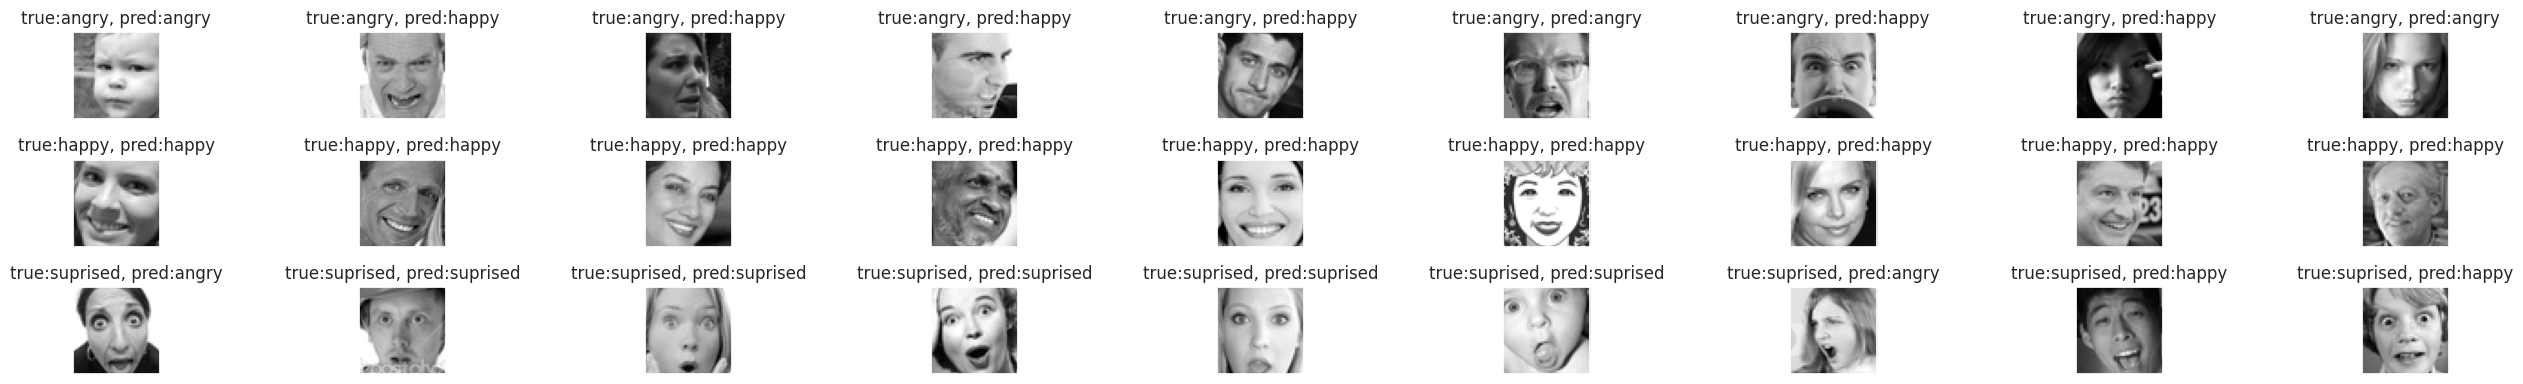

In [ ]:
# check some images model got wrong
figure = plotGraph.figure(1, (27,4))

map_emotions ={
    0: "angry",
    1: "happy",
    2: "suprised"
}

np.random.seed(2)

random_angry_images = np.random.choice(
    np.where(y_Test[:,0] == 1)[0],
    size=9
)

random_happy_images = np.random.choice(
    np.where(y_Test[:,1] == 1)[0],
    size=9
)
  

random_surprised_images = np.random.choice(
    np.where(y_Test[:,2]==1)[0],
    size=9
    )


for i, (angry_index, happy_index, surprised_index) in enumerate(zip(random_angry_images, random_happy_images, random_surprised_images)):
  ax = plotGraph.subplot(3,9, i+1)
  sample_image = x_Test[angry_index,:,:]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])
  sample_prediction = model_from_paper2.predict(sample_image.reshape(1,48,48))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:angry, pred:{map_emotions[sample_class_prediction]}")
  

  ax = plotGraph.subplot(3,9, i+10)
  sample_image = x_Test[happy_index,:,:]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model_from_paper2.predict(sample_image.reshape(1,48,48))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:happy, pred:{map_emotions[sample_class_prediction]}")

  ax = plotGraph.subplot(3,9, i+19)
  sample_image = x_Test[surprised_index,:,:]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = model_from_paper2.predict(sample_image.reshape(1,48,48))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:suprised, pred:{map_emotions[sample_class_prediction]}")

plotGraph.tight_layout()



# Save Model

In [ ]:
# save model
model_from_paper2.save(
    "/content/drive/MyDrive/17644_MoodDetectives/RNN_Models-Three_Emotions/5_Layer_RNN_Model/Three_Emotions/FER2013/rnn_model_paper2_stopped.h5"
    )


# New Model

In [ ]:
new_model = build_RNN(optims[2])  

Model: "Three_Emotion_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simpleRNN_1 (SimpleRNN)     (None, 48, 64)            7232      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 64)           256       
 tion)                                                           
                                                                 
 simpleRNN_2 (SimpleRNN)     (None, 48, 64)            8256      
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 64)           256       
 tion)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 48, 64)            0         
                                                                 
 simpleRNN_3 (SimpleRNN)     (None, 48, 64)      

In [ ]:
history_of_new_model = new_model.fit(
    x_Train, y_Train,
    validation_data = (x_Test, y_Test),
    steps_per_epoch = len(x_Train)/batch_size,
    epochs=epochs,
    callbacks = callbacks_new_model,
    use_multiprocessing = True
    )

Epoch 1/100
448/448 [==============================] - 134s 286ms/step - loss: 1.8058 - accuracy: 0.3722 - val_loss: 1.0527 - val_accuracy: 0.5013 - lr: 6.2500e-05
Epoch 2/100
448/448 [==============================] - 125s 278ms/step - loss: 1.6008 - accuracy: 0.3903 - val_loss: 1.0519 - val_accuracy: 0.5065 - lr: 6.2500e-05
Epoch 3/100
448/448 [==============================] - 124s 276ms/step - loss: 1.4841 - accuracy: 0.4077 - val_loss: 1.0511 - val_accuracy: 0.5116 - lr: 6.2500e-05
Epoch 4/100
448/448 [==============================] - 126s 280ms/step - loss: 1.3988 - accuracy: 0.4223 - val_loss: 1.0317 - val_accuracy: 0.5205 - lr: 6.2500e-05
Epoch 5/100
445/448 [============================>.] - ETA: 0s - loss: 1.3260 - accuracy: 0.4370
Epoch 5: saving model to /content/drive/MyDrive/17644_MoodDetectives/RNN_Models-Three_Emotions/19_Layer_RNN_Model/Three_Emotions/FER2013/Checkpoints/rnn_fer2013_model_epoch5.h5
448/448 [==============================] - 125s 279ms/step - loss: 1.3

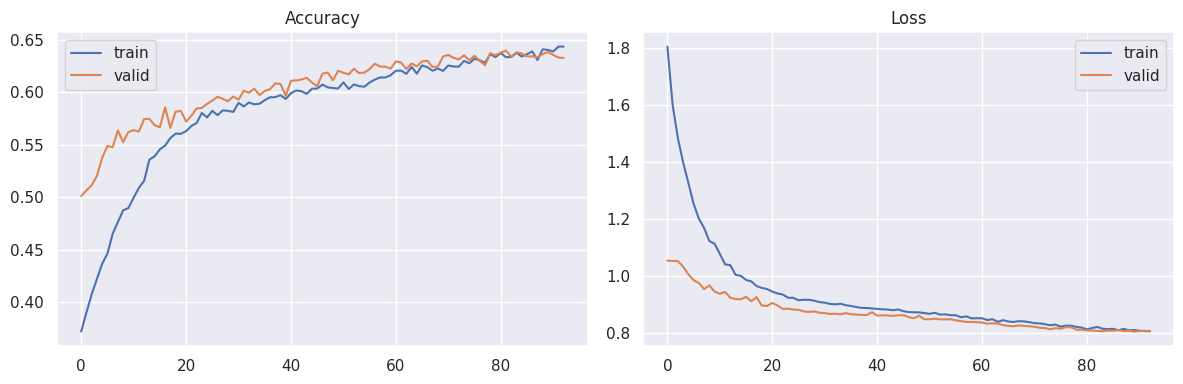

In [ ]:
# metrics

sb.set()
figure = plotGraph.figure(0, (12,4))

# Plot Accuracy
ax = plotGraph.subplot(1,2,1)
sb.lineplot(
    x = history_of_new_model.epoch,
    y = history_of_new_model.history["accuracy"], 
    label="train"
)

sb.lineplot(
    x = history_of_new_model.epoch,
    y = history_of_new_model.history["val_accuracy"], 
    label="valid"
)

plotGraph.title("Accuracy")
plotGraph.tight_layout()

# Plot Loss
ax = plotGraph.subplot(1,2,2)
sb.lineplot(
    x = history_of_new_model.epoch,
    y = history_of_new_model.history["loss"], 
    label="train"
)

sb.lineplot(
    x = history_of_new_model.epoch,
    y = history_of_new_model.history["val_loss"], 
    label="valid"
)

plotGraph.title("Loss")
plotGraph.tight_layout()

In [ ]:
# acccuracy

new_model_prediction = new_model.predict(x_Test)

accuracy_score( np.argmax(y_Test,axis=1) , np.argmax(new_model_prediction, axis =1) )

113/113 [==============================] - 3s 24ms/step


0.6397325160211759

113/113 [==============================] - 3s 27ms/step


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

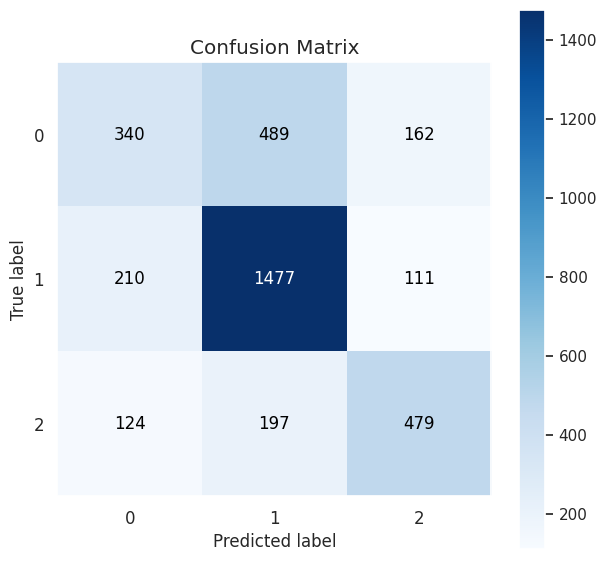

In [ ]:
# Confusion Matrix

new_model_predictions = new_model.predict(x_Test)
new_model_class_predictions = np.argmax(new_model_predictions, axis=1)

scikitplot.metrics.plot_confusion_matrix(
    np.argmax(y_Test, axis=1),
    new_model_class_predictions,
    figsize=(7,7)
)

In [ ]:
print(
    "Total Wrong Predictions:", 
      np.sum(
          np.argmax(y_Test, axis=1) != new_model_class_predictions
      )
    )

print(
    classification_report(
    np.argmax(y_Test, axis=1), new_model_class_predictions
    )
  )

Total Wrong Predictions: 1293
              precision    recall  f1-score   support

           0       0.50      0.34      0.41       991
           1       0.68      0.82      0.75      1798
           2       0.64      0.60      0.62       800

    accuracy                           0.64      3589
   macro avg       0.61      0.59      0.59      3589
weighted avg       0.62      0.64      0.62      3589



1/1 [==============================] - 0s 42ms/step


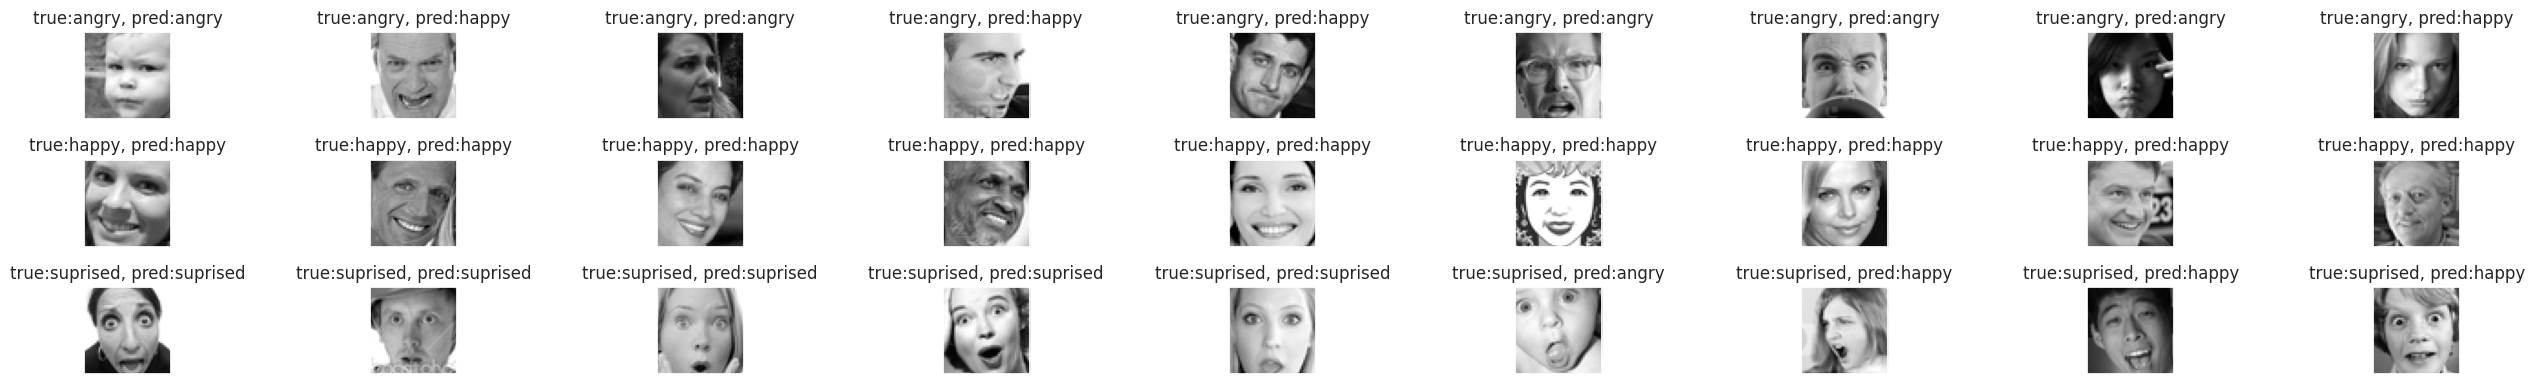

In [ ]:
# check some images model got wrong
figure = plotGraph.figure(1, (27,4))

map_emotions ={
    0: "angry",
    1: "happy",
    2: "suprised"
}

np.random.seed(2)

random_angry_images = np.random.choice(
    np.where(y_Test[:,0] == 1)[0],
    size=9
)

random_happy_images = np.random.choice(
    np.where(y_Test[:,1] == 1)[0],
    size=9
)
  

random_surprised_images = np.random.choice(
    np.where(y_Test[:,2]==1)[0],
    size=9
    )


for i, (angry_index, happy_index, surprised_index) in enumerate(zip(random_angry_images, random_happy_images, random_surprised_images)):
  ax = plotGraph.subplot(3,9, i+1)
  sample_image = x_Test[angry_index,:,:]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])
  sample_prediction = new_model.predict(sample_image.reshape(1,48,48))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:angry, pred:{map_emotions[sample_class_prediction]}")
  

  ax = plotGraph.subplot(3,9, i+10)
  sample_image = x_Test[happy_index,:,:]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = new_model.predict(sample_image.reshape(1,48,48))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:happy, pred:{map_emotions[sample_class_prediction]}")

  ax = plotGraph.subplot(3,9, i+19)
  sample_image = x_Test[surprised_index,:,:]
  ax.imshow(sample_image, cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])

  sample_prediction = new_model.predict(sample_image.reshape(1,48,48))
  sample_class_prediction = np.argmax(sample_prediction)
  # print(sample_class_prediction)
  # print(map_emotions[sample_class_prediction])
  ax.set_title(f"true:suprised, pred:{map_emotions[sample_class_prediction]}")

plotGraph.tight_layout()



In [ ]:
# save model
new_model.save(
    "/content/drive/MyDrive/17644_MoodDetectives/RNN_Models-Three_Emotions/19_Layer_RNN_Model/Three_Emotions/FER2013/nn_new_model.h5"
    )
